In [1]:
%matplotlib inline

import pandas as pd
import os
import csv
import numpy as np
import random
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [2]:
cur_dir = os.path.dirname('__file__')
data = pd.read_csv(os.path.join(cur_dir, "WDI_Data.csv"))

In [3]:
def preprocess(df):
    """Create a 21st column, which is the average of a certain stat since the year 2000."""
    df = df.copy()
    df['21st'] = df.ix[:, '2000':].mean(axis=1)
    df['Obama'] = df.ix[:, '2011':'2015'].mean(axis=1)
    df['Reagan'] = df.ix[:, '1983':'1988'].mean(axis=1)
    return df

In [4]:
def one_year(data, year='21st'):
    """Averages all statistics over the course of the 21st century, and create a dataframe where each
    row is a country, and each column is a statistic.
    """
    grouped = data.groupby('Indicator Name')
    indic_dict = {}
    for indicator, group in grouped:
        for index, row in group.iterrows():
            if indicator not in indic_dict:
                indic_dict[indicator] = []
            indic_dict[indicator].append(row[year])
    for indicator, group in grouped:
        names = group['Country Name'].tolist()
        break   
        
    df = pd.DataFrame(indic_dict, index=names)
    return df


def only_countries(df, n=None, data_thresh=0):
    """Filter the input df and remove all rows that do not represent a country. (For example, there is one row the
    World.)"""
    if n is None:
        n = len(df)
    words = ['World', 'income', '(developing only)', 'OECD', 'countries', 'Euro', 'Asia', 'America', 'situations', 'states']
    sel = []
    for i in df.index:
        temp = filled_pct(df.loc[i]) > data_thresh
        for w in words:
            if w in i:
                temp = False
        sel.append(temp)
        
    return df[sel].iloc[:n]

def few_na_cols(df, thresh=0, required_countries=[]):
    """Remove all columns that do not have thresh proportion of values filled in. required_countries are countries that
    must have a value in a column for it to be kept."""
    res = []
    for c in df.columns:
        perc = filled_pct(df[c])
        meets_required = True
        for count in required_countries:
            if df[c].isnull().loc[count]:
                meets_required = False
        if perc > thresh and meets_required:
            res.append(c)
    return df[res]

def highest_pop_df(df, n=None, by='Population, total'):
    """Return the dataframe, sorted by population."""
    if n is None:
        n = len(df)
    df = df.sort_values(by,ascending=False)
    return df.iloc[:n]

def filled_pct(col):
    return float(col.notnull().sum()) / len(col)

def get_unique_cols(df, thresh=0.95):
    uniques = df.columns.tolist()
    corr_df = df.corr()
    i = 0
    while i < len(uniques):
        j = 0
        while j < len(uniques):
            if i != j:
                col1 = uniques[i]
                col2 = uniques[j]
                r_sq = corr_df[col1].loc[col2] ** 2
                if r_sq >= thresh:
                    if filled_pct(df[col1]) > filled_pct(df[col2]):
                        drop_index = j
                    elif filled_pct(df[col1]) < filled_pct(df[col2]):
                        drop_index = i
                    else:
                        drop_index = i
                    uniques.pop(drop_index)
                    if drop_index == i:
                        i = i - 1
                        break
            j += 1
        i += 1
    return uniques
                    
                
    corr = df.corr()
    for col in corr:
        corr[col].loc[col]
        break
        

def get_data_availability(df):
    """Get a dataframe containing the percentage of rows for each column that is not NaN"""
    null_pcts = []

    for column in df.columns:
        col = df[column]
        n = filled_pct(col)
        null_pcts.append(n)


    temp = pd.DataFrame(data=null_pcts, index=df.columns,
                        columns=['Data Availability']).sort_values('Data Availability', ascending=False)
    return temp

In [5]:
def create_group_csv(csv_dwnld, save_to):
    """Call this function after downloading a csv for a single country, for a single year, for a group of indicators.
    This function exports the indicator names to a csv."""

    data = pd.read_csv(os.path.join(cur_dir, csv_dwnld))
    education_stats = data['Series Name'].tolist()

    with open(save_to, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(education_stats)
        
def get_indicator_list_from_csv(csv_file):
    """And then this gets the corresponding indicator list from the csv."""
    with open(csv_file) as f:
        reader = csv.reader(f)
        your_list = list(reader)
    l = your_list[0]
    l = [s for s in l if s != "nan"]
    return l

"""
# example usage
create_group_csv('Data_Extract_From_World_Development_Indicators_Data.csv', 'health.csv')
health_indicators = get_indicator_list_from_csv('health.csv')
"""

"\n# example usage\ncreate_group_csv('Data_Extract_From_World_Development_Indicators_Data.csv', 'health.csv')\nhealth_indicators = get_indicator_list_from_csv('health.csv')\n"

In [43]:
def cluster_label_dict(countries, clustering):
    """Takes in a list of countries and a cluster, and returns a dictionary mapping from cluster to a list
    of countries in that cluster"""
    label_dict = {}

    for index, label in enumerate(clustering.labels_):
        label_dict[countries[index]] = label
    return label_dict

def filter_df(df, features, n=None, country_data_thresh=0, column_data_thresh=.8):
    highest_pop = highest_pop_df(df)[features]
    highest_pop = highest_pop[get_unique_cols(highest_pop)]

    countries = only_countries(highest_pop, n=n, data_thresh=country_data_thresh)
    economics = few_na_cols(countries, thresh=column_data_thresh)

    sample = economics.fillna(economics.mean())
    return sample



def cluster_highest_pop_countries(df, filter=False, features=None, n=None, m=3, country_data_thresh=0, column_data_thresh=.8):
    """This helper function clusters the highest n populated countries into m clusters. It returns the cluster, a
    cluster dictionary creating using cluster_label_dict(), X_red - a spectrical embedding of the data into two dimensions,
    and the list of countries."""
    if filter:
        if features is None:
            features = df.columns
        sample = filter_df(df, features, n=n, country_data_thresh=country_data_thresh,
                           column_data_thresh=column_data_thresh)
    else:
        sample = df
        
    countries = sample.index
    
    X = sample.as_matrix()
    X = StandardScaler().fit_transform(X)
    n_samples, n_features = X.shape
    
    X_red = manifold.SpectralEmbedding(n_components=1).fit_transform(X)
    position_dic = {}
    for i in range(len(countries)):
        position_dic[countries[i]] = X_red[i, 0]
    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
    
    print "Clustering using %i columns for %i countries..." % (sample.shape[1], sample.shape[0])

    clustering = AgglomerativeClustering(linkage='ward', n_clusters=m)
    clustering.fit(X)
    clust_dict = cluster_label_dict(countries, clustering)
    reorder_dictionary(clust_dict, position_dic)
    
    return sample, clustering, clust_dict, X_red, countries, position_dic

def plot_clustering(X_red, clustering, countries, title=None, reverse=False, save_name=''):
    """Plots a clustering of countries. Takes in X_red, the cluster object, and the list of countries."""
    labels = clustering.labels_
    if reverse:
        labels = [max(labels) - l + min(labels) for l in labels]
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    us_index = -1
    for i in range(X_red.shape[0]):
        if (countries[i] == 'United States'):
            us_index = i
            continue
        plt.text(X_red[i, 0], X_red[i, 1], str(countries[i])[:3],
                 color=map_to_color(labels[i], min(labels), max(labels)),
                 fontdict={'weight': 'bold', 'size': 15})
        
    if (us_index != -1):
        plt.text(X_red[us_index, 0], X_red[us_index, 1], 'U.S.',
                 color='black',
                 fontdict={'weight': 'bold', 'size': 25})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    if save_name: plt.gcf().savefig(os.path.join(cur_dir, 'img', save_name + ".eps"))
    
def map_to_color(label, label_min, label_max):
    fraction = float(label - label_min) / (label_max - label_min)
    mapped = fraction
    return plt.get_cmap('Spectral')(mapped)
    
def remap_countries(country_list):
    d = {'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', 'Burma': 'Myanmar',
         "Lao People's Democratic Republic": "Lao PDR", 'Cape Verde': "Cabo Verde", 'Saint Lucia': 'St. Lucia',
         "Slovakia": "Slovak Republic", "Saint Vincent and the Grenadines": "St. Vincent and the Grenadines",
         "Kyrgyzstan": "Kyrgyz Republic", "The former Yugoslav Republic of Macedonia": "Macedonia, FYR",
         "Korea, Democratic People's Republic of": "Korea, Dem. Rep.", "Korea, Republic of": "Korea, Rep."
        }
    temp = []
    for c in country_list:
        if c in d:
            temp.append(d[c])
        else:
            temp.append(c)
    return temp
    
def plot_map(clust_dict, reverse=False, save_name=''):
    '''Use dict of labels and clusters of countries to create a world map color-coded by label'''
    
    #Create map object and load world countries Shapefiles
    m = Basemap(projection='mill')
    m.readshapefile('Borders/world', name='countries', drawbounds=True)
    
    country_names = [shape_dict['NAME'] for shape_dict in m.countries_info]
    country_names = remap_countries(country_names)
    ax = plt.gca()
    labels = [label for country, label in clust_dict.iteritems()]
            
    for country, label in clust_dict.iteritems():
        if reverse:
            label = max(labels) - label + min(labels)
        found = False
        color = map_to_color(float(label), min(labels), max(labels))
        #Countries with non-contiguous landmasses are constructed as multiple polygons
        
        country_indices = []
        
        for i, c in enumerate(country_names):
            if c.lower() in country.lower() or country.lower() in c.lower():
                country_indices.append(i)
                found = True
                
        if not found:
            print country + " was not found!"
        
        segs = [m.countries[index] for index in country_indices]
        polys = [Polygon(seg, facecolor=color, edgecolor=color) for seg in segs]
        [ax.add_patch(poly) for poly in polys]
        
#     m.drawmapboundary(fill_color='aqua')
    plt.gcf().set_size_inches(20,10)
    if save_name: plt.gcf().savefig(os.path.join(cur_dir, 'img', save_name + ".eps"))
    
    plt.show()
    return country_names

def reorder_dictionary(clust_dic, pos_dic):
    clust = pd.DataFrame.from_dict({'group': clust_dic, 'one_d': pos_dic})
    means = clust.groupby('group').mean()
    means = means.sort_values('one_d', ascending=False)
    ind = means.index.tolist()
    for key, value in clust_dic.iteritems():
        clust_dic[key] = ind.index(value)

def cluster_means(dic, df):
    df = df.copy()
    df2 = df.copy()
    df['Name'] = df.index
    
    X = StandardScaler().fit_transform(df2.as_matrix())
    df2 = pd.DataFrame(data=X, index=df2.index, columns=df2.columns)
    
    df2['Group'] = df.Name.map(dic)
    
    means = {}
    for name, group in df2.groupby('Group'):
        means[name] = group.mean()
        
    return means

    
def mean_diffs(means_dic1, group1, group2):
    diff = (means_dic1[group1] - means_dic1[group2])
    temp = pd.DataFrame({'dif': diff})
    temp['abs_val'] = temp.dif.abs()
    temp = temp.sort_values('abs_val', ascending=False)
    return temp.dif

def feature_intersection(df1, df2):
    return list(set(df1.columns).intersection(set(df2.columns)))
    

In [7]:
data = preprocess(data) # create the 21st column

In [8]:
df = one_year(data, year='21st')
Reagan = one_year(data, year='Reagan') # create a dataframe using the 21st columns
Obama = one_year(data, year='Obama') # create a dataframe using the 21st columns

In [9]:
# create our feature lists

features = {}
groups = ['health', 'education', 'economics', 'environment']

for g in groups:
    features[g] = get_indicator_list_from_csv(g + '.csv')
    if 'Population, total' in features[g]:
        features[g].remove('Population, total')
    
features['all'] = df.columns.tolist()

In [52]:
clusters = 4
feat='education'

res_df_r = filter_df(Reagan, features[feat], country_data_thresh=0.1, column_data_thresh=0.5)
res_df_o = filter_df(Obama, features[feat], country_data_thresh=0.1, column_data_thresh=0.5)
feat_int = feature_intersection(res_df_r, res_df_o)

res_df_r, clust_r, dic_r, X_red_r, countries_r, pos_dic_r = \
    cluster_highest_pop_countries(res_df_r[feat_int], m=clusters)
res_df_o, clust_o, dic_o, X_red_o, countries_o, pos_dic_o = \
    cluster_highest_pop_countries(res_df_o[feat_int], m=clusters)


Clustering using 26 columns for 192 countries...
Clustering using 26 columns for 205 countries...


In [67]:
reverse_r = False
reverse_o = False

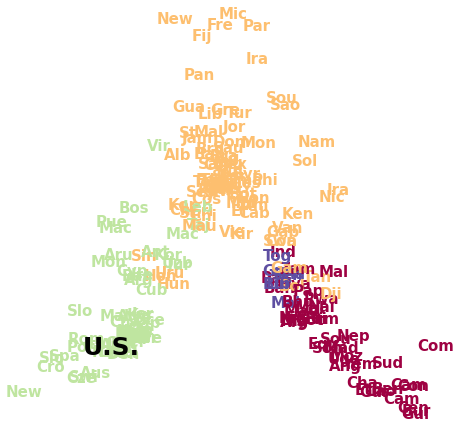

In [68]:
plot_clustering(X_red_r, clust_r, countries_r, reverse=reverse_r)
plt.gcf().set_size_inches(6, 6)

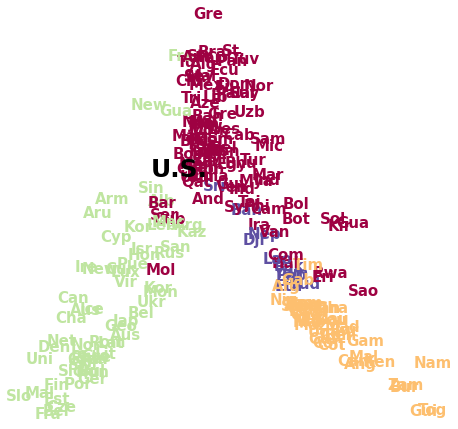

In [69]:
plot_clustering(X_red_o, clust_o, countries_o, reverse=reverse_o)
plt.gcf().set_size_inches(6, 6)

Channel Islands was not found!
Vietnam was not found!
Micronesia, Fed. Sts. was not found!
Virgin Islands (U.S.) was not found!
St. Kitts and Nevis was not found!


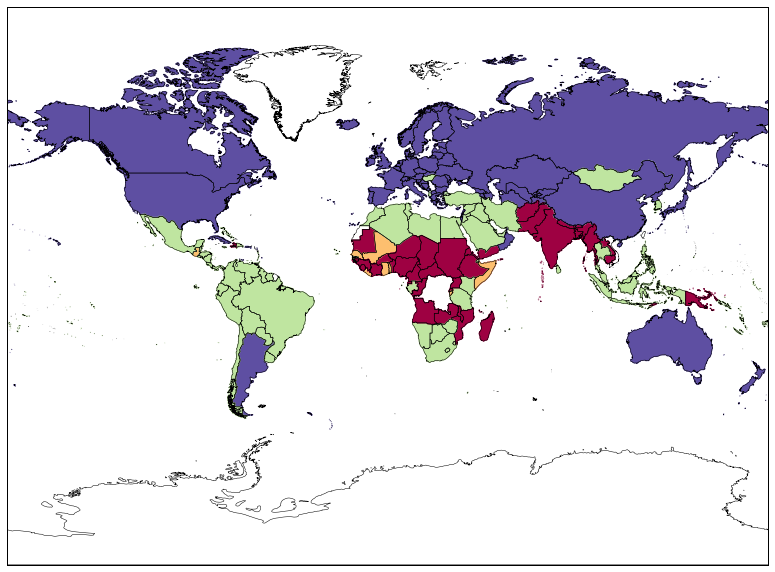

In [70]:
countries_mapped = plot_map(dic_r, reverse=reverse_r)

Channel Islands was not found!
West Bank and Gaza was not found!
Vietnam was not found!
Micronesia, Fed. Sts. was not found!
Virgin Islands (U.S.) was not found!
St. Kitts and Nevis was not found!
Curacao was not found!


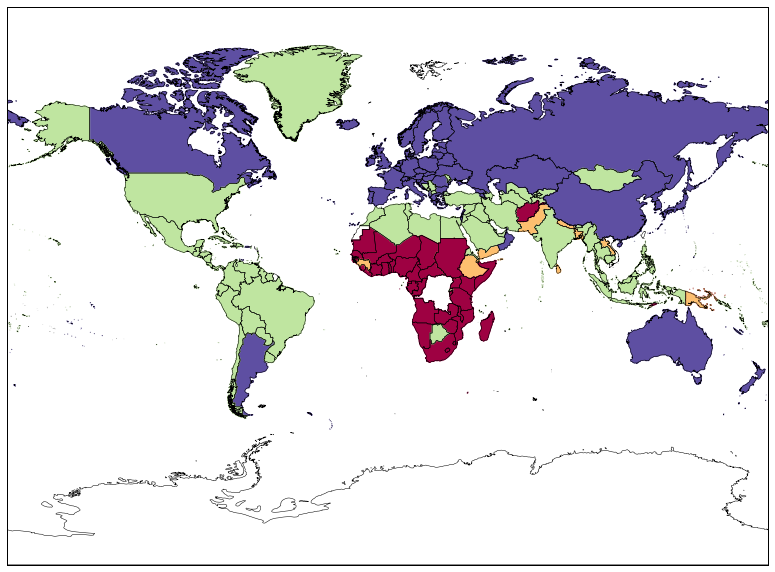

In [71]:
countries_mapped = plot_map(dic_o, reverse=reverse_o)

In [60]:
print "Difference between extremes"
means_r = cluster_means(dic_r, res_df_r)
print mean_diffs(means_r, clusters-1, 0)[0:4]

Group                                                      3.000000
Mortality rate, adult, female (per 1,000 female adults)   -2.351850
Life expectancy at birth, total (years)                    2.323500
Birth rate, crude (per 1,000 people)                      -2.231965
Name: dif, dtype: float64


In [61]:
means_o = cluster_means(dic_o, res_df_o)
print mean_diffs(means_o, clusters-1, clusters-2)[0:4]

Population ages 65 and above (% of total)    1.562111
Physicians (per 1,000 people)                1.104120
Hospital beds (per 1,000 people)             1.062527
Group                                        1.000000
Name: dif, dtype: float64
